In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("..\\model_training\\data\\u00_sensing_data.csv")
df.columns

Index([&#39;timestamp&#39;, &#39;conversation&#39;, &#39;bt_level_avg&#39;, &#39;bt_level_std&#39;,
       &#39;bt_total_devices_around&#39;, &#39;bt_total_far&#39;, &#39;bt_total_farther&#39;,
       &#39;bt_total_near&#39;, &#39;bt_total_nearer&#39;, &#39;wifi_level_avg&#39;, &#39;wifi_level_std&#39;,
       &#39;wifi_total_devices_around&#39;, &#39;wifi_total_far&#39;, &#39;wifi_total_near&#39;,
       &#39;wifi_total_nearer&#39;, &#39;phone_in_dark&#39;, &#39;phone_charging&#39;, &#39;phone_locked&#39;,
       &#39;activity_inference_0&#39;, &#39;activity_inference_1&#39;, &#39;activity_inference_2&#39;,
       &#39;activity_inference_3&#39;, &#39;audio_inference_0&#39;, &#39;audio_inference_1&#39;,
       &#39;audio_inference_2&#39;, &#39;audio_inference_3&#39;],
      dtype=&#39;object&#39;)

### Set timestamp index

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)
df["hours"] = df.index.hour
df["days"] = df.index.map(lambda x: x.strftime("%b-%d"))
#df.head()

#### Computes features from original sampling

In [8]:
df["main_activity"] = df[["activity_inference_0", "activity_inference_1", "activity_inference_2", "activity_inference_3"]].idxmax(axis="columns")
df["main_audio"] = df[["audio_inference_0", "audio_inference_1", "audio_inference_2"]].idxmax(axis="columns")

scaler = MinMaxScaler((-1, 1))
df["now_in_dark"] = scaler.fit_transform(df[["phone_in_dark"]].where(df == 600, other=0).diff()) #{-1: "now dark", 1: "no longer dark"}
df["now_charging"] = scaler.fit_transform(df[["phone_charging"]].where(df == 600, other=0).diff()) #{-1: "now charging", 1: "no longer charging"}
df["now_locked"] = scaler.fit_transform(df[["phone_locked"]].where(df == 600, other=0).diff()) #{-1: "now locked", 1: "now unlocked"}
#df.tail()

### Aggregates features over set seasons

In [9]:
group_df = df.groupby(pd.Grouper(freq="H", base=-4, label="right"))
#group_df.groups


In [10]:
agg_df = group_df.agg({"conversation" : "sum",
                       "bt_total_devices_around" : "mean",
                       "wifi_total_devices_around" : "max",
                       "phone_in_dark" : "sum",
                       "phone_charging" : "sum", 
                       "phone_locked" : "sum"
                       })

count_x = lambda x: x[x == 1].count()
agg_df["count_now_dark"] = group_df["now_in_dark"].apply(count_x)
agg_df["count_now_charging"] = group_df["now_charging"].apply(count_x)
agg_df["count_locked"] = group_df["now_locked"].apply(count_x)
#agg_df.tail()

[&lt;matplotlib.lines.Line2D at 0x16dbb0c0e48&gt;]

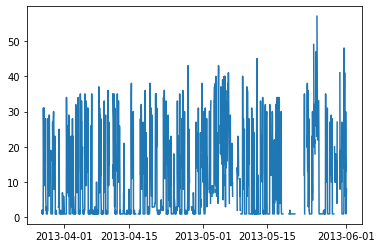

In [7]:
plt.plot(agg_df[["wifi_total_devices_around"]])